# -1) install la librairie "findSpark"

In [1]:
!pip install findspark

# 0) configure 'findspark'

In [1]:
import findspark

In [2]:
spark_home = "/Users/romainjouin/Downloads/spark-3.1.2-bin-hadoop3.2"
findspark.init(spark_home=spark_home, )

# 1) configure spark

In [3]:
from pyspark         import SparkConf
from pyspark.context import SparkContext
from pyspark.sql     import SparkSession

## 1.1) création d'une configuration

In [4]:
master_url = "spark://romainjouin-macbookpro1.roam.corp.google.com:7077"
nb_cpu     = 4
App_name   = "Nom de l'application" 

[Propriétés de Spark](https://spark.apache.org/docs/latest/configuration.html#available-properties)

In [5]:
conf = SparkConf()
conf = conf.setMaster(master_url)
conf = conf.set("spark.cores.max", nb_cpu)
conf = conf.setAppName(App_name)


## 1.2) creation d'un spark context

In [6]:
try    : sc.stop()
except : pass

In [7]:
sc = SparkContext(conf=conf)

In [8]:
sc

<SparkContext master=spark://romainjouin-macbookpro1.roam.corp.google.com:7077 appName=Nom de l'application>

# 2) lecture d'un fichier parquet file (slide 212)

In [9]:
spark_dir            = "./../../Downloads/spark-3.1.2-bin-hadoop3.2"
path_to_parquet_file = f"{spark_dir}/examples/src/main/resources/users.parquet"
path_to_readme       = f"{spark_dir}/README.md"

# Coder une requête sql en map reduce
SELECT   mot, count(mot)  
FROM     fichier  
WHERE    len(mot)>3  
GROUP BY mot  
LIMIT    10

In [10]:
import re
from pyspark.sql import functions as F
from operator import add

In [11]:
fichier        = sc.textFile(path_to_readme)
mots           = fichier.flatMap(lambda ligne: re.split("\W+", ligne.lower().strip()))
mots_de_3_car  = mots.filter(lambda mot : len(mot)>3)
k_v            = mots_de_3_car.map(lambda mot: (mot, 1))
denombrement   = k_v.reduceByKey(add)
dix_examples   = denombrement.take(10)
dix_examples

[('unified', 1),
 ('analytics', 1),
 ('engine', 2),
 ('large', 1),
 ('provides', 1),
 ('high', 1),
 ('scala', 4),
 ('java', 1),
 ('python', 4),
 ('optimized', 1)]

# 3) création d'une spark session 

In [12]:
spark_Session = SparkSession.builder.getOrCreate()

In [13]:
spark_Session

## 3.1) utiliser la sparkSession pour lire des CSV avec headers

In [14]:
reader = spark_Session.read.option("header", "true")
type(reader)

pyspark.sql.readwriter.DataFrameReader

In [15]:
path_to_csv = "./cycliste_debug.csv"

In [16]:
df = reader.csv(path_to_csv)

In [17]:
df.head()

Row(cycliste='cycliste_azey2', n_message='0442', time=' 1486038900.39', message='velo rendu sur la station azgb6 ( a la maison = False) (elem de station_travail)')

## 3.2) possible de convertir la DataFrame en RDD 

Les dataframes sont bassées sur des RDD
En spark 1 les RDD étaient les objets de bases, maintenant on promeut plutôt les df => qui ont un schéma est sont plus optimisées

In [18]:
rdd = df.rdd

In [19]:
rdd.take(3)

[Row(cycliste='cycliste_azey2', n_message='0442', time=' 1486038900.39', message='velo rendu sur la station azgb6 ( a la maison = False) (elem de station_travail)'),
 Row(cycliste='cycliste_azey2', n_message='0441', time=' 1486038900.39', message='impossible de rendre sur '),
 Row(cycliste='cycliste_azey2', n_message='0440', time=' 1486038900.38', message='self.a_la_maison = False')]

# 4) Sql Context

In [20]:
from pyspark import SQLContext

## 4.1) création du sql context

In [21]:
sqlContext = SQLContext(sc)

## 4.2) lecture d'un fichier => création dataframe

In [22]:
df = sqlContext.read.load(path_to_parquet_file)

In [23]:
df.head(5)

[Row(name='Alyssa', favorite_color=None, favorite_numbers=[3, 9, 15, 20]),
 Row(name='Ben', favorite_color='red', favorite_numbers=[])]

## 4.3) enregistrement d'une table temporaire en mémoire acceptant ensuite des requêtes SQL

In [24]:
nom_de_la_table = "XY"
sqlContext.registerDataFrameAsTable(df, nom_de_la_table)

In [25]:
requete_sql = f"""
                    Select name, count(*)
                    FROM {nom_de_la_table}
                    group by name
"""
sql_result = sqlContext.sql(requete_sql)
sql_result.collect()


[Row(name='Ben', count(1)=1), Row(name='Alyssa', count(1)=1)]

In [26]:
!ls

cycliste_debug.csv spark.ipynb        spark3.ipynb       spark_2.ipynb


# 5) Création d'une dataFrame

In [27]:

df = sqlContext.read.option("header", "true").option("inferschema", "true").csv("./cycliste_debug.csv")

In [28]:
df

DataFrame[cycliste: string, n_message: int, time: double, message: string]

## 5.1) afficher la liste des colonnes

In [29]:
df.columns

['cycliste', 'n_message', 'time', 'message']

## 5.2) ajouter une colonne, résultat d'un calcul sur une colonne

In [30]:

df2 = df.withColumn("time * 2", df.time*2)

In [31]:
df2.head()

Row(cycliste='cycliste_azey2', n_message=442, time=1486038900.39, message='velo rendu sur la station azgb6 ( a la maison = False) (elem de station_travail)', time * 2=2972077800.78)

## 5.3) renommer une colonne

In [32]:
df3 = df2.withColumnRenamed("time * 2", "2_*_time")
df3.columns

['cycliste', 'n_message', 'time', 'message', '2_*_time']

## 5.4) Random split

In [33]:
_80_pct, _12_pct, _8_pct =  df3.randomSplit([0.8, 0.12, 0.08])

In [34]:
_80_pct.count(), _12_pct.count(), _8_pct.count()

(466912, 69936, 46125)

## 5.5) cacher en mémoire : pour aller plus vite

In [35]:
_ = df3.cache()

In [36]:
type(_)

pyspark.sql.dataframe.DataFrame

In [37]:
_.is_cached

True

In [38]:
df3.is_cached

True

In [39]:
_.count()

582973

In [40]:
df3.count()

582973

# 5.6) revenir sur du pur python, en rapatriant les résultats en pandas

In [41]:
instance_pandas = df3.toPandas()

In [42]:
# on retrouve l'interface pandas / le display
instance_pandas

,cycliste,n_message,time,message,2_*_time
0,cycliste_azey2,442.0,1.486039e+09,velo rendu sur la station azgb6 ( a la maison ...,2.972078e+09
1,cycliste_azey2,441.0,1.486039e+09,impossible de rendre sur,2.972078e+09
2,cycliste_azey2,440.0,1.486039e+09,self.a_la_maison = False,2.972078e+09
3,cycliste_azey2,439.0,1.486039e+09,True a pris le velo velo_aelcv_1486034979.01 s...,2.972078e+09
4,cycliste_azefc,616.0,1.486039e+09,impossible de rendre sur,2.972078e+09
...,...,...,...,...,...
582968,cycliste_azogn,3.0,1.486320e+09,station_travail nearest= azkv8|aru48|azrlw|aet...,2.972640e+09
582969,cycliste_azogn,2.0,1.486320e+09,station_maison nearest= azrp5|azuod|aztpw|aztx...,2.972640e+09
582970,cycliste_azogn,1.0,1.486320e+09,station_travail = aehwv,2.972640e+09
582971,cycliste_azogn,0.0,1.486320e+09,station_maison = azk16,2.972640e+09


## Il n'y a pas d'outil de visualisation inclu dans spark => revenir à python permet de faire de la dataviz avec les outils pythons 

<AxesSubplot:>

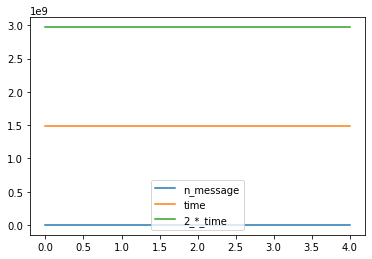

In [43]:
instance_pandas.head().plot()


# 7) Manipulation d'une dataframe spark

# 7.1) afficher des colonnes

In [62]:
colonnes_voulues = ["cycliste", "message"]
n = 3
sample=0.01
df[colonnes_voulues].sample(sample).collect()

[Row(cycliste='cycliste_azes0', message='pas de velo sur la station arupl '),
 Row(cycliste='cycliste_azeql', message='impossible de rendre sur '),
 Row(cycliste='cycliste_azeru', message='Aucun velo trouve aux alentours.'),
 Row(cycliste='cycliste_azed1', message='self.a_la_maison = False'),
 Row(cycliste='cycliste_azed0', message='pas de velo sur la station aesjv '),
 Row(cycliste='cycliste_azeog', message='velo rendu sur la station azgb6 ( a la maison = False) (elem de station_travail)'),
 Row(cycliste='cycliste_azetw', message='impossible de rendre sur '),
 Row(cycliste='cycliste_azeul', message='impossible de rendre sur '),
 Row(cycliste='cycliste_azeqj', message='impossible de rendre sur '),
 Row(cycliste='cycliste_azeu2', message='True a pris le velo velo_aelb3_1486391533.03 sur la station azlb5'),
 Row(cycliste='cycliste_azew0', message='True a pris le velo velo_azin1_1486391533.9 sur la station arf46'),
 Row(cycliste='cycliste_azsb2', message='station_travail nearest= azmx4|ae

## 7.2) extraire de la data d'une colonne

In [55]:
df.where(df["cycliste"]== "cycliste_azey2").collect()

[Row(cycliste='cycliste_azey2', n_message=442, time=1486038900.39, message='velo rendu sur la station azgb6 ( a la maison = False) (elem de station_travail)'),
 Row(cycliste='cycliste_azey2', n_message=441, time=1486038900.39, message='impossible de rendre sur '),
 Row(cycliste='cycliste_azey2', n_message=440, time=1486038900.38, message='self.a_la_maison = False'),
 Row(cycliste='cycliste_azey2', n_message=439, time=1486038897.85, message='True a pris le velo velo_aelcv_1486034979.01 sur la station ars89'),
 Row(cycliste='cycliste_azey2', n_message=9, time=1486391567.2, message='velo rendu sur la station aejw5 ( a la maison = False) (elem de station_travail)'),
 Row(cycliste='cycliste_azey2', n_message=8, time=1486391567.2, message='impossible de rendre sur '),
 Row(cycliste='cycliste_azey2', n_message=7, time=1486391567.2, message='impossible de rendre sur '),
 Row(cycliste='cycliste_azey2', n_message=6, time=1486391567.2, message='self.a_la_maison = False'),
 Row(cycliste='cycliste_